# Extract seasonality patterns from climate data with Fast Fourier Transform (FFT)

Last edited:
<br> December, 9 2020

### Import libraries

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from pylab import *
from math import *

import warnings
warnings.simplefilter('ignore')

import numpy as np 
from numpy.fft import fftfreq
from scipy.fftpack import *
from scipy.signal import butter, filtfilt , freqz

import pandas as pd

### Read data

First things first, prepare the data that going to be analyzed. For example, I use 37-years daily precipitation from CHIRPS which is rainfall estimates from rain gauge and satellite observations. The data has been cropped at the specific BMKG Station in Bandung, named Cemara Weather Station. Since CHIRPS data more complete than BMKG data, I personally prefer to use CHIRPS rather than use BMKG data despite the considerable discrepancy in the data when compared.

In [4]:
prec = pd.read_csv('prec_chirps.csv')
prec.head()

,date,prec
0,1/1/1981,13.128672
1,1/2/1981,0.000000
2,1/3/1981,0.000000
3,1/4/1981,0.000000
4,1/5/1981,0.000000


### Data Wrangle

Check whether the column has null null values.

In [5]:
prec.isnull().sum()

date    0
prec    0
dtype: int64

There are various ways on handling null value. Should you find nulls in your data, please check this artcle: https://medium.com/bycodegarage/a-comprehensive-guide-on-handling-missing-values-b1257a4866d1

### Plot the Data

In [24]:
#create array of indices that correspond with the start date of each year
year_indices = np.array([0,365,730,1096,1461,1826,2191,2557,2922,3287,3652,4018,
                4383,4748,5113,5479,5844,6209,6574,6940,7305,7670,8035,8401,8766,
                9131,9496,9862,10227,10592,10957,11323,11688,12053,12418,12784,13149,13514])
years = np.arange(1981,2019,dtype=object)

Text(0.5, 0, 'Time')

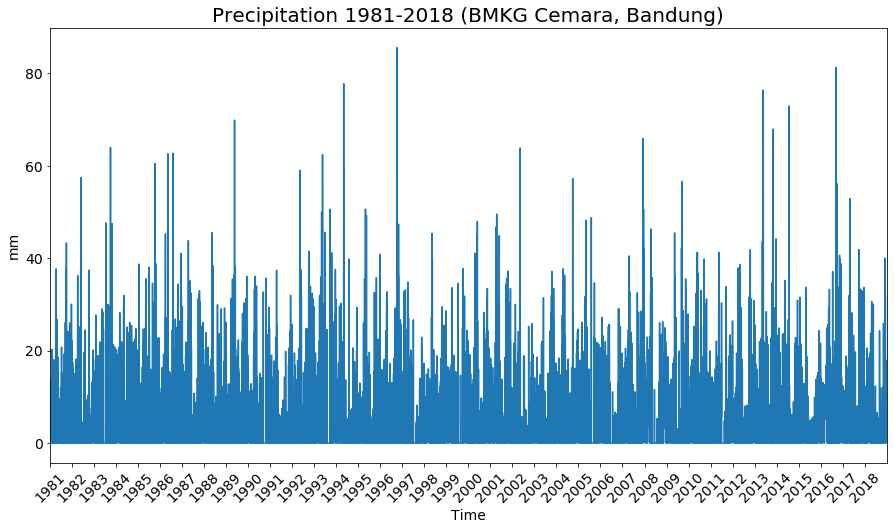

In [25]:
plt.figure(figsize=(15,8))
plt.plot(prec['prec'])
plt.xticks(year_indices,years,rotation=45,fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0,13879)
plt.title('Precipitation 1981-2018 (BMKG Cemara, Bandung)',fontsize=20)
plt.ylabel('mm',fontsize=14)
plt.xlabel('Time',fontsize=14)

The figure shows the daily precipitation (mm) from 1st January of 1981 until 31st December of 2018.

In [29]:
# For the better grasp, we will plot the precipitation as a monthly average.
# Read the monthly average data.
month_prec = pd.read_csv('monthly_average.csv')
month_prec.head()

,month,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,ave
0,Jan,146.620238,177.567667,137.171890,207.772595,213.841846,123.121592,142.628528,218.893661,197.891902,...,205.502027,172.069815,150.585744,278.606761,304.079219,173.929164,141.041328,192.479285,153.874764,187.808426
1,Feb,111.887667,142.871644,197.607454,182.828605,146.452318,148.125887,165.239900,141.018321,170.488434,...,227.412392,109.186078,150.956374,145.003398,221.443803,226.777097,203.626904,143.649008,203.996338,170.663645
2,Mar,174.698314,207.463876,226.922044,215.315372,181.041784,258.874112,215.544235,204.388699,199.669322,...,271.287451,187.839315,160.166436,202.742646,209.615578,200.593017,238.127644,208.164457,217.098178,206.254234
3,Apr,268.657123,273.473449,303.099034,262.615547,257.058143,332.519371,162.988737,148.194307,294.211300,...,242.475565,270.086993,302.924867,257.257929,330.369138,203.210023,312.937362,347.837278,231.759205,270.834483
4,May,198.521432,107.572071,257.169279,272.606664,176.560358,98.478535,304.270010,218.931038,452.266582,...,477.047697,270.718624,168.997517,550.209986,226.757346,116.958189,270.653434,235.347261,156.254160,224.206036


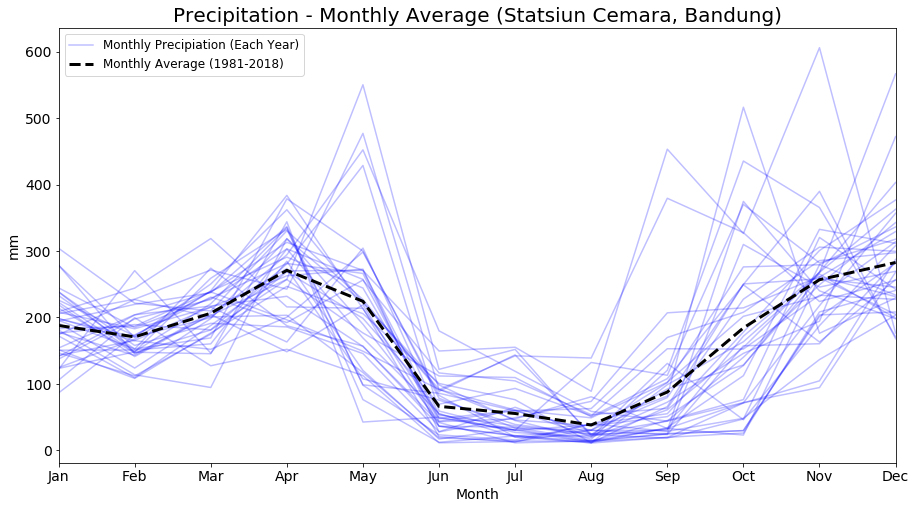

In [34]:
plt.figure(figsize=(15,8))

month_idx = np.arange(0,12)
months = np.array(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
for i in range (0,36):
    plt.plot(month_prec[str(1981+i)],c="b",alpha=0.25)

plt.plot(month_prec['2018'],c="b",alpha=0.25,label="Monthly Precipiation (Each Year)")
plt.plot(month_prec["ave"],c="k",alpha=1,linewidth=3,linestyle="--",label="Monthly Average (1981-2018)")
plt.xticks(month_idx,months,fontsize=14)
plt.yticks(fontsize=14)
plt.title("Precipitation - Monthly Average (Statsiun Cemara, Bandung)",fontsize=20)
plt.ylabel("mm",fontsize=14)
plt.xlabel("Month",fontsize=14)
plt.xlim(0,11)
plt.legend(loc=0,fontsize=12)

Now we have a better overview of rain seasonality in Bandung. This wavy pattern transpires one time a year and some years may have shifted of peak and trough of the rainy season. Notwithstanding, the pattern remains.

### FFT !

In [35]:
#set the distance between two data samples, ex: 3 hour per day or monthly.
dt = 1

#sample size
n = prec.shape[0] 

In [36]:
#Apply FFT to data!
F = fft(prec['prec'])

In [38]:
#Compute the sample frequency, the unit will align with the dt unit that we've applied.
w = fftfreq(n, dt)

Then, set a new variable that portrays the number of periodicity types of the signal whereby the length is half of the original data. After that, select only indices for elements that correspond to positive frequencies. To know the details about why we do this step, check this thread: https://dsp.stackexchange.com/questions/4825/why-is-the-fft-mirrored

In [39]:
#
n/2

6939.5

In [40]:
t=np.linspace(1, n, n)

In [41]:
T = n/t[0:6939]

In [42]:
indices = where(w > 0) #only take the positive frequency
w_pos = abs(w[indices])
F_pos = abs(F[indices]) 

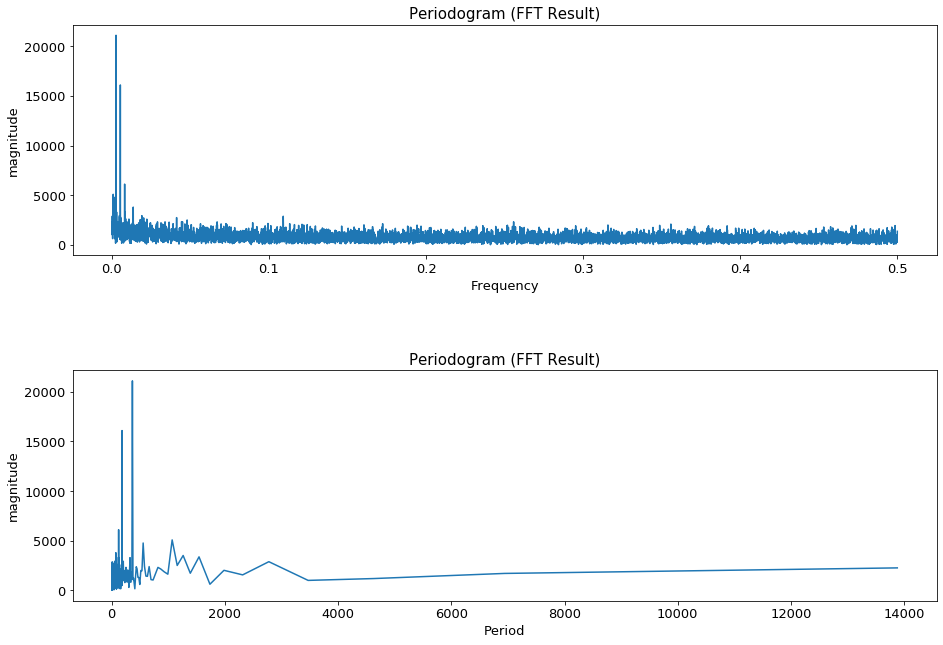

In [43]:
#Plot hasil dari proses FFT di atas
fig1 = plt.figure()
ax = fig1.add_axes([0, 0, 2, 0.8])
axF = fig1.add_axes([0, 1.2, 2, 0.8])

axF.plot(w_pos, abs(F_pos))
axF.set_xlabel('Frequency', fontsize = 13)
axF.set_ylabel('magnitude', fontsize = 13)
axF.set_title('Periodogram (FFT Result)', fontsize = 15)
# axF.set_xticks([1/15, 0.1, 0.2, 0.3, 0.4, 0.5])
axF.tick_params(labelsize = 13)

ax.plot(T, abs(F_pos))
ax.set_xlabel('Period', fontsize = 13)
ax.set_ylabel('magnitude', fontsize = 13)
ax.set_title('Periodogram (FFT Result)', fontsize = 15)
# ax.set_xticks([5, 10, 15,  20, 25, 30, 35])
# ax.set_xlim([0, 60])
ax.tick_params(labelsize = 13)

The range of periodogram looks too wide, we have to limit the period/frequency range (x-axis) and only highlight the region with high amplitde. By limiting the x-axis range, we get the clear-cut of the periodicity ranges which have a significant amplitude in forming the original data.

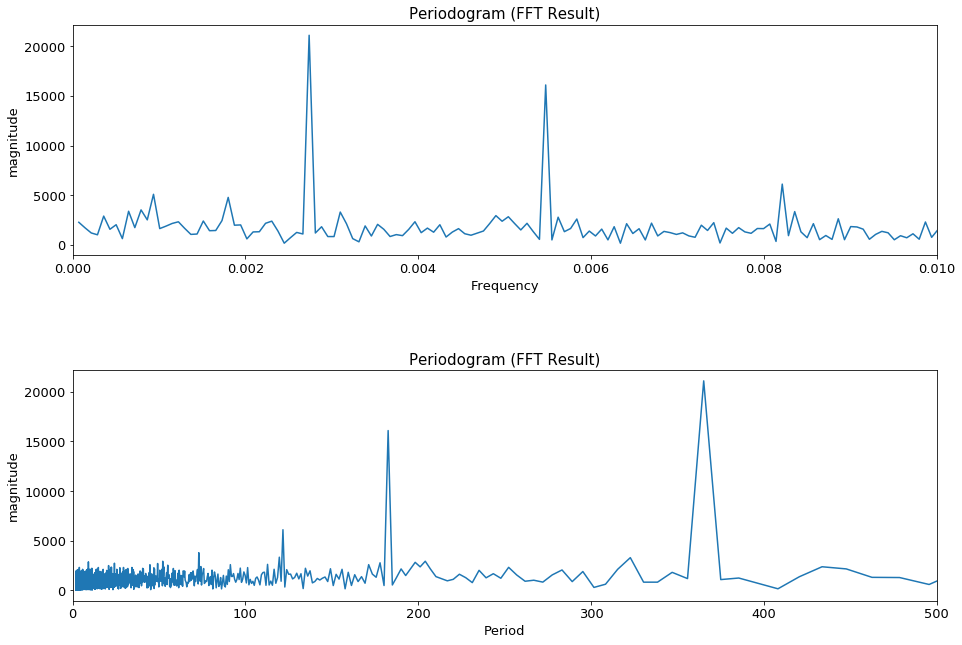

In [44]:
#Plot hasil dari proses FFT di atas
fig1 = plt.figure()
ax = fig1.add_axes([0, 0, 2, 0.8])
axF = fig1.add_axes([0, 1.2, 2, 0.8])

axF.plot(w_pos, abs(F_pos))
axF.set_xlabel('Frequency', fontsize = 13)
axF.set_ylabel('magnitude', fontsize = 13)
axF.set_title('Periodogram (FFT Result)', fontsize = 15)
# axF.set_xticks([1/15, 0.1, 0.2, 0.3, 0.4, 0.5])
axF.tick_params(labelsize = 13)
axF.set_xlim(0,0.01)

ax.plot(T, abs(F_pos))
ax.set_xlabel('Period', fontsize = 13)
ax.set_ylabel('magnitude', fontsize = 13)
ax.set_title('Periodogram (FFT Result)', fontsize = 15)
# ax.set_xticks([5, 10, 15,  20, 25, 30, 35])
ax.set_xlim([0, 500])
ax.tick_params(labelsize = 13)

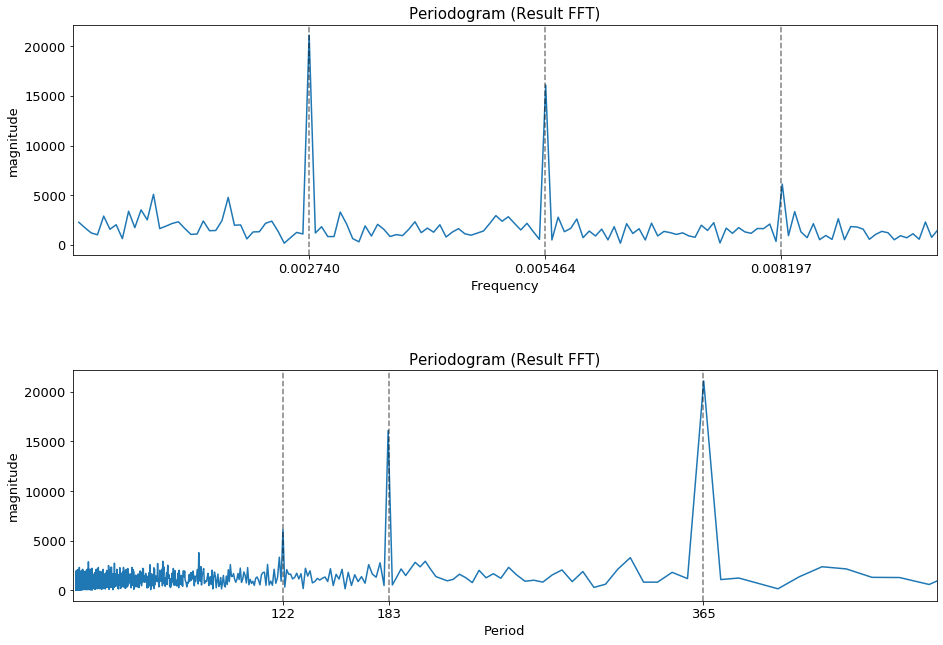

In [132]:
#Plot hasil dari proses FFT di atas
fig1 = plt.figure()
ax = fig1.add_axes([0, 0, 2, 0.8])
axF = fig1.add_axes([0, 1.2, 2, 0.8])

axF.plot(w_pos, abs(F_pos))
axF.set_xlabel('Frequency', fontsize = 13)
axF.set_ylabel('magnitude', fontsize = 13)
axF.set_title('Periodogram (Result FFT)', fontsize = 15)
# axF.set_xticks([1/15, 0.1, 0.2, 0.3, 0.4, 0.5])
axF.set_xticks([1/122,1/183,1/365])
axF.axvline(x=1/365,c='k',alpha=0.5,linestyle='--')
axF.axvline(x=1/183,c='k',alpha=0.5,linestyle='--')
axF.axvline(x=1/122,c='k',alpha=0.5,linestyle='--')
axF.tick_params(labelsize = 13)
axF.set_xlim(0,0.01)

ax.plot(T, abs(F_pos))
ax.set_xlabel('Period', fontsize = 13)
ax.set_ylabel('magnitude', fontsize = 13)
ax.set_title('Periodogram (Result FFT)', fontsize = 15)
# ax.set_xticks([5, 10, 15,  20, 25, 30, 35])
ax.set_xticks([122,183,365])
ax.axvline(x=365,c='k',alpha=0.5,linestyle='--')
ax.axvline(x=183,c='k',alpha=0.5,linestyle='--')
ax.axvline(x=122,c='k',alpha=0.5,linestyle='--')
ax.set_xlim([0, 500])
ax.tick_params(labelsize = 13)

Without being examined, 365-days periodicity has the highest amplitude as I mentioned earlier. It clearly represents the most common and well-known of Bandung rain seasonality (annual seasonality). The second highest amplitude is on 183-days (6-month, semi-annual seasonality) and the third is on 122-days (4-month, quarter-annual seasonality). It turns out that Bandung rain seasonality is not only transpired annually, but it also has semi-annual and quarter-annual patterns, nevertheless, the amplitude is not quite high which means that the patterns are less frequent to exist over the time scope of the data.